- perform sample by sample
  - LGG1 : Mouse2
  - LGG2 : Mouse3
  - LGG3 : Mouse4
  - HGG : Mouse1
- paga
- recalculate embedding + oligodendrocyte
  - hvg 2000 vs 3000
- consider `cellrank2`

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import scanpy as sc
import scanpy.external as sce
import scvelo as scv

import numpy as np
import pandas as pd

# Concat
- recalculate GFP+ embeding?

In [142]:
os.listdir('../output/velo/')
adatas = [sc.read_h5ad('../output/velo/' + f) for f in os.listdir('../output/velo/') if f.endswith('.h5ad') and f.startswith('Mouse')]
adata = sc.concat(adatas)
adata = adata[adata.obs.cell_type.isin(['OPC', 'Oligodendrocytes', 'Tumor', 'COP']) & adata.obs.GFP.isin(['GFP+'])].copy()
del adata.obsm
adata.obs.cell_type.value_counts()

cell_type
Tumor               8041
OPC                 1694
Oligodendrocytes     272
COP                  143
Name: count, dtype: int64

- scVI integration

In [2]:
import os
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

# scRNA-seq analysis pipeline
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import numpy as np
import celltypist

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
%matplotlib inline

# Models & Calculation
from scipy.stats import median_abs_deviation as mad
import scipy.sparse as sp
import scvi
from scvi import autotune
from ray import tune
import ray

In [3]:
adata = sc.read_h5ad('../output/velo/concat.h5ad')

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, layer = 'counts', flavor = 'seurat_v3', batch_key = 'sample_id') 

In [5]:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts', batch_key='sample_id')
model = scvi.model.SCVI(adata) 

In [6]:
model.train(early_stopping=True)

INFO: GPU available: True (mps), used: False
GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 2230.362. Signaling Trainer to stop.


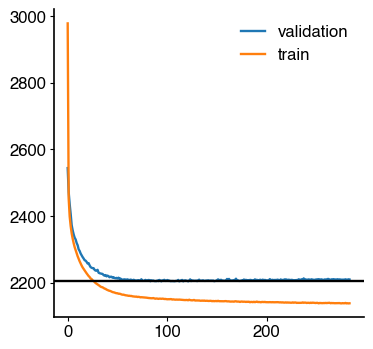

In [7]:
with mplscience.style_context():
    y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
    plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label = 'validation')
    plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [8]:
adata.obsm['X_scVI'] = model.get_latent_representation()

In [9]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model= model,adata = adata, labels_key = 'cell_type', unlabeled_category='unlabelled')

In [10]:
scanvi_model.train(max_epochs = 30, early_stopping = True)

INFO     Training for 30 epochs.                                                                                   


INFO: GPU available: True (mps), used: False
GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/30 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
`Trainer.fit` stopped: `max_epochs=30` reached.


In [11]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation()
sc.pp.neighbors(adata, use_rep = 'X_scANVI')
sc.tl.umap(adata)

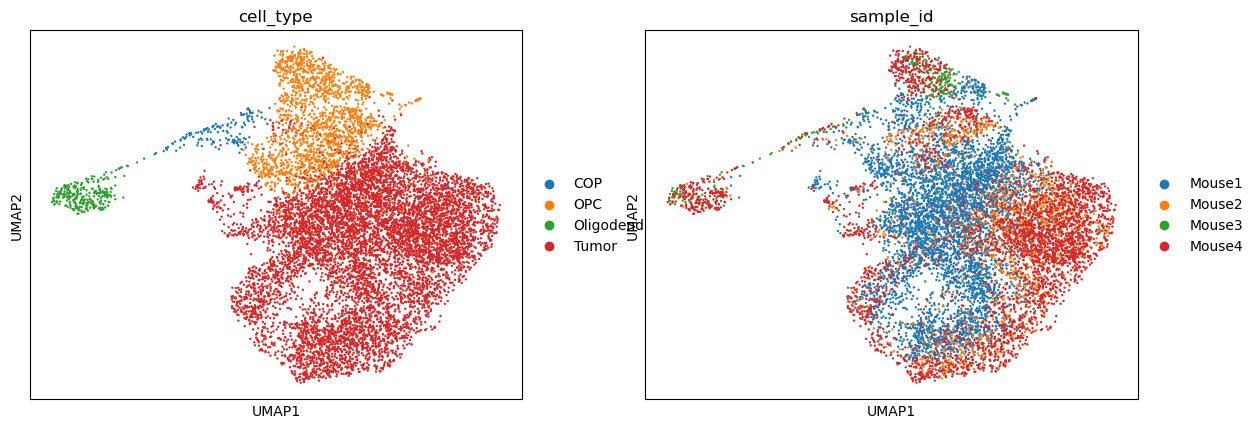

In [12]:
sc.pl.umap(adata, color = ['cell_type', 'sample_id'])

In [13]:
# adata.write('../output/velo/corrected.h5ad')
adata.write('../output/velo/corrected_3000.h5ad')

## RNA velocity

In [93]:
# bdata = sc.read_h5ad('../output/velo/corrected_3000.h5ad')
bdata = sc.read_h5ad('../output/velo/corrected.h5ad')
adata = sc.read_h5ad('../output/velo/concat.h5ad')

In [94]:
adata.obsm['X_scANVI'] = bdata.obsm['X_scANVI']
adata.obsm['X_scVI'] = bdata.obsm['X_scVI']
adata.obsm['X_umap'] = bdata.obsm['X_umap']
adata.obsp['connectivities'] = bdata.obsp['connectivities']
adata.obsp['distances'] = bdata.obsp['distances']
del bdata

### 1-1. just scANVI rep

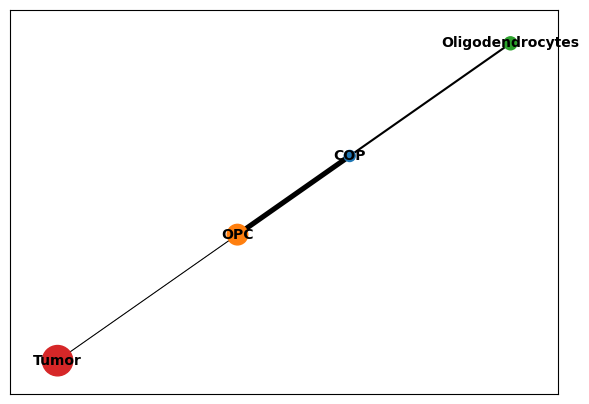

In [95]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_scANVI")
sc.tl.paga(adata, groups='cell_type')
sc.pl.paga(adata, color = 'cell_type')
sc.tl.draw_graph(adata, init_pos='paga')

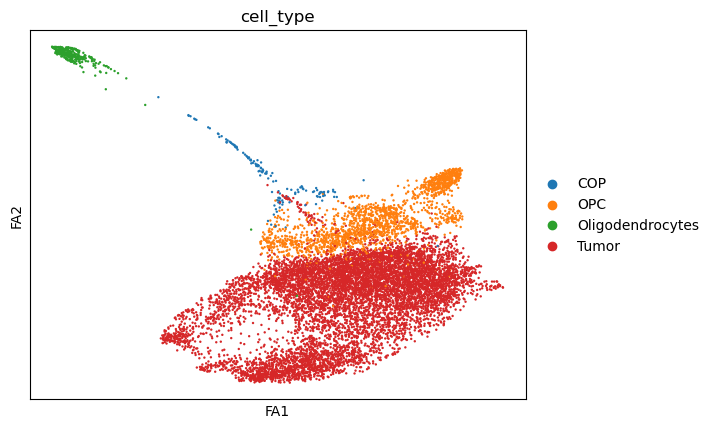

In [96]:
sc.pl.draw_graph(adata, color = 'cell_type')

### 1-2. Denoising

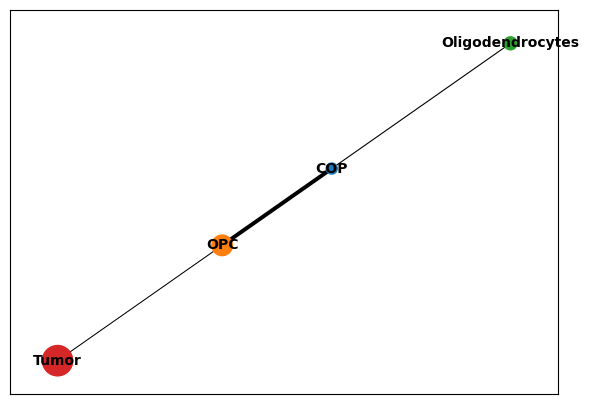

In [20]:
sc.pp.neighbors(adata, n_neighbors=4, use_rep='X_scANVI') # use scANVI?
sc.tl.draw_graph(adata)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_diffmap")
sc.tl.paga(adata, groups='cell_type')
sc.pl.paga(adata, color = 'cell_type')
sc.tl.draw_graph(adata, init_pos='paga')

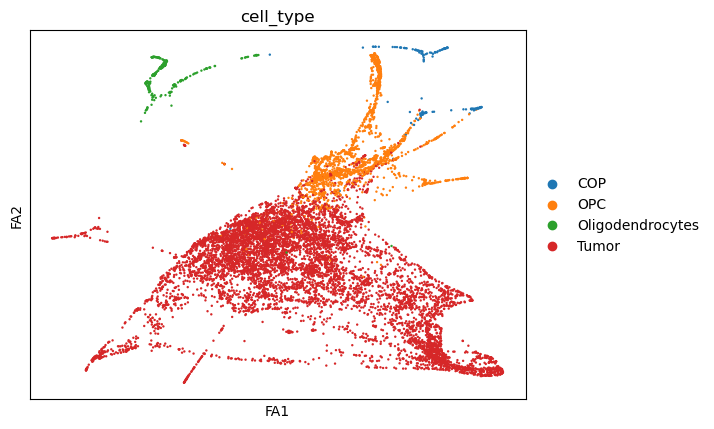

In [21]:
sc.pl.draw_graph(adata, color = 'cell_type')

### 2. run scVelo pipeline

In [97]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 17511 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [98]:
# deterministic
# scv.tl.velocity(adata, mode = 'deterministic')

# stochastic
# scv.tl.velocity(adata, mode = 'stochastic')

# dynamical
scv.tl.recover_dynamics(adata, n_jobs = 16)
scv.tl.velocity(adata, mode = 'dynamical')

recovering dynamics (using 16/16 cores)


  0%|          | 0/452 [00:00<?, ?gene/s]

    finished (0:00:30) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [99]:
scv.tl.velocity_graph(adata, n_jobs = 16)

computing velocity graph (using 16/16 cores)


  0%|          | 0/10150 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### 3 - 1. Run CellRank

In [10]:
import cellrank as cr
import scanpy as sc
import numpy as np

In [4]:
# adata.write('../output/velo/cr2000.h5ad')
adata = sc.read_h5ad('../output/velo/cr2000.h5ad')
vk = cr.kernels.VelocityKernel(adata)

/Users/jiehoonk/micromamba/envs/cellrank/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
vk.compute_transition_matrix()

100%|██████████| 10150/10150 [00:00<00:00, 11786.69cell/s]


VelocityKernel[n=10150, model='deterministic', similarity='correlation', softmax_scale=np.float64(5.988)]

In [6]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

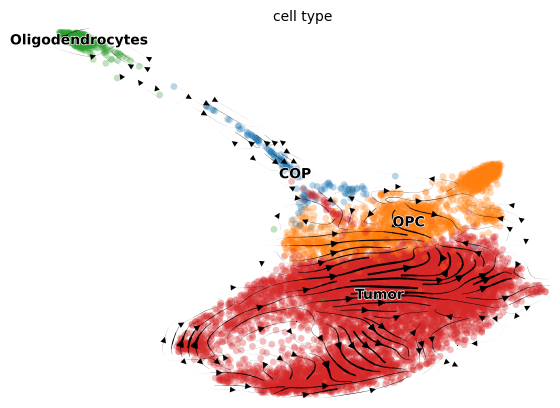

In [18]:
vk.plot_projection(basis = 'draw_graph_fa', color = 'cell_type')

100%|██████████| 100/100 [00:01<00:00, 50.33sim/s]


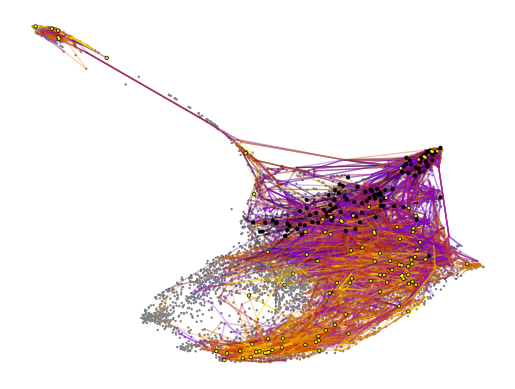

In [19]:
vk.plot_random_walks(start_ixs={"cell_type": "OPC"}, max_iter=200, seed=777, basis = 'draw_graph_fa')


### 3 - 2. Run PAGA

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

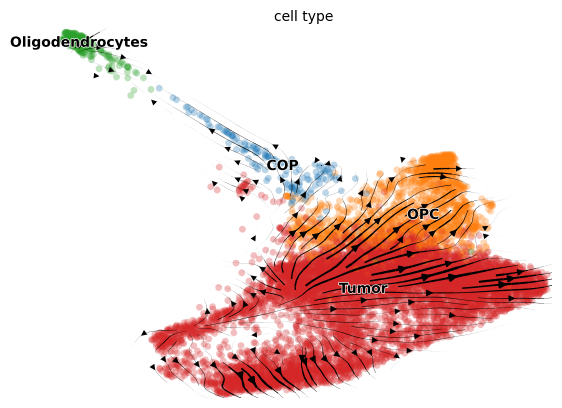

In [86]:
# scv.pl.velocity_embedding_stream(adata, basis='umap', color = 'cell_type') # draw_graph_fa
scv.pl.velocity_embedding_stream(adata, basis='draw_graph_fa', color = 'cell_type') # draw_graph_fa

/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

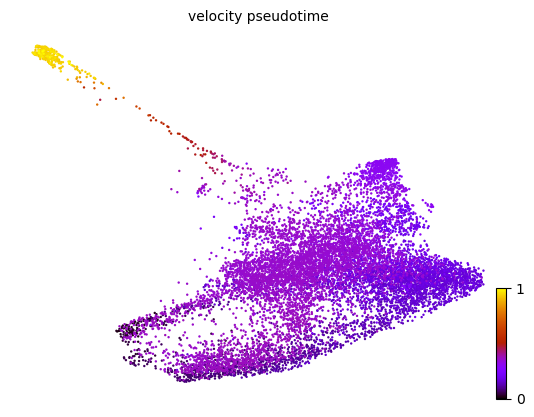

In [87]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', basis = 'draw_graph_fa')
# scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', basis = 'umap')

In [88]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='cell_type')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

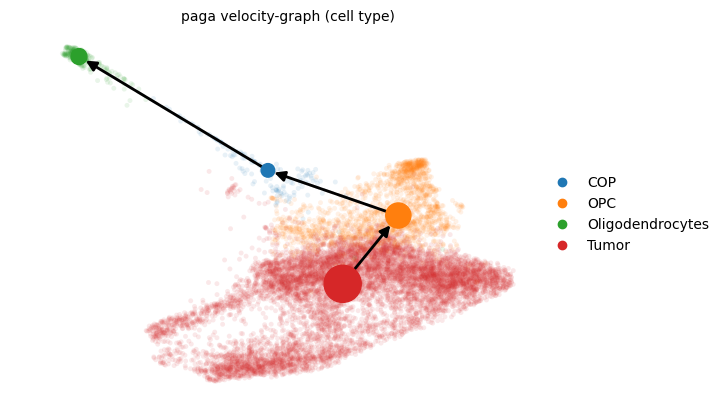

In [89]:
scv.pl.paga(adata, basis='draw_graph_fa', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)
# scv.pl.paga(adata, basis='umap', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5)

# Mouse 1,2, 4

In [73]:
adata = sc.read_h5ad('../output/velo/Mouse4.h5ad')
adata = adata[adata.obs.cell_type.isin(['OPC', 'Oligodendrocytes', 'Tumor', 'COP']) & adata.obs.GFP.isin(['GFP+'])].copy()
del adata.obsm
adata.obs.cell_type.value_counts()

cell_type
Tumor               2616
OPC                  441
Oligodendrocytes     190
COP                   28
Name: count, dtype: int64

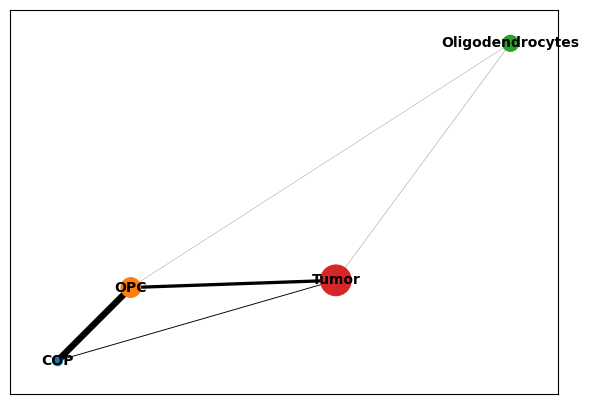

In [74]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=True, span = 0.5)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_diffmap")
sc.tl.paga(adata, groups='cell_type')
sc.pl.paga(adata, color = 'cell_type')
sc.tl.draw_graph(adata, init_pos='paga')

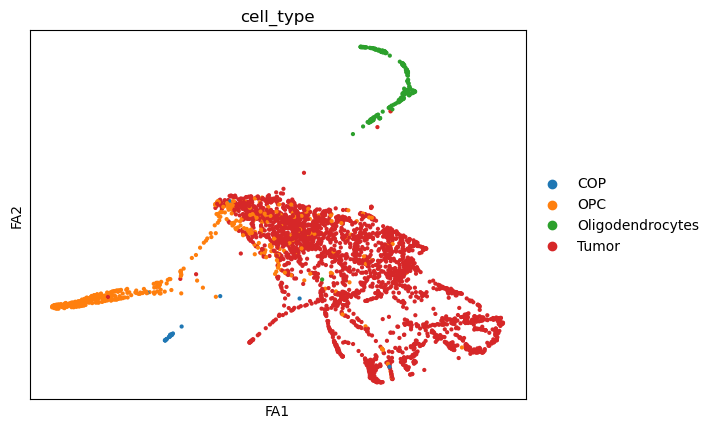

In [75]:
sc.pl.draw_graph(adata, color = 'cell_type')

In [76]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

Normalized count data: spliced, unspliced.


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


/var/folders/9t/4v6202wn5_n62qf58gr7mf3r0000gn/T/ipykernel_67440/233639239.py:2: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata)
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [77]:
# deterministic
# scv.tl.velocity(adata, mode = 'deterministic')

# stochastic
scv.tl.recover_dynamics(adata, n_jobs = 16)
scv.tl.velocity(adata, mode = 'stochastic')

recovering dynamics (using 16/16 cores)


  0%|          | 0/364 [00:00<?, ?gene/s]

    finished (0:00:12) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [78]:
scv.tl.velocity_graph(adata, n_jobs = 16)

computing velocity graph (using 16/16 cores)


  0%|          | 0/3275 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

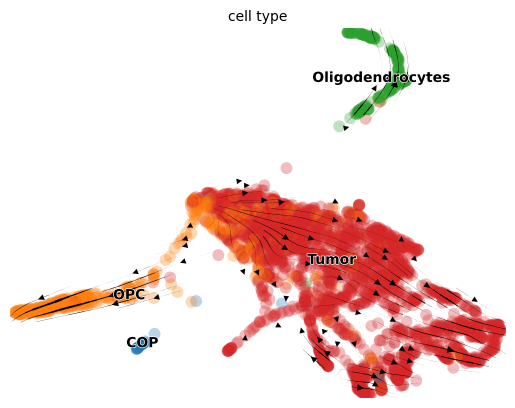

In [86]:
scv.pl.velocity_embedding_stream(adata, basis='draw_graph_fa', color = 'cell_type')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

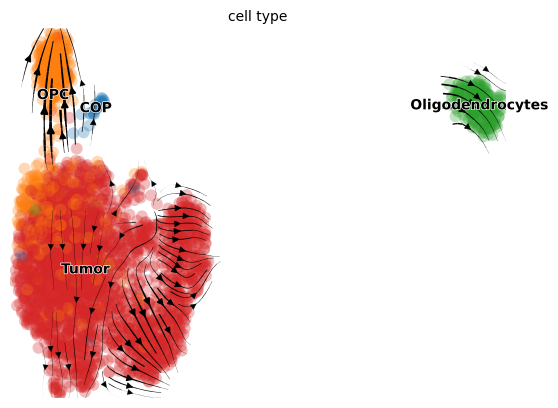

In [80]:
sc.tl.umap(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color = 'cell_type')

computing terminal states
    identified 4 regions of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

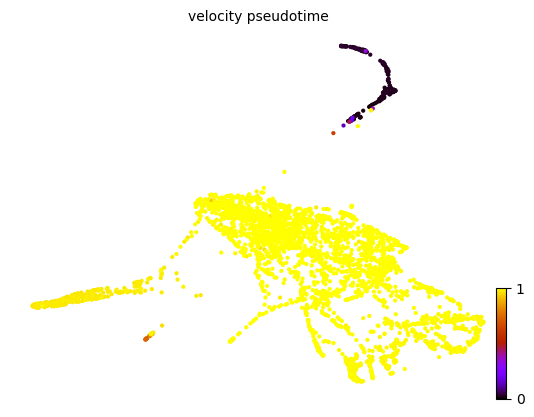

In [81]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', basis = 'draw_graph_fa')

In [82]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='cell_type')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/jiehoonk/micromamba/envs/scvelo/lib/pyt

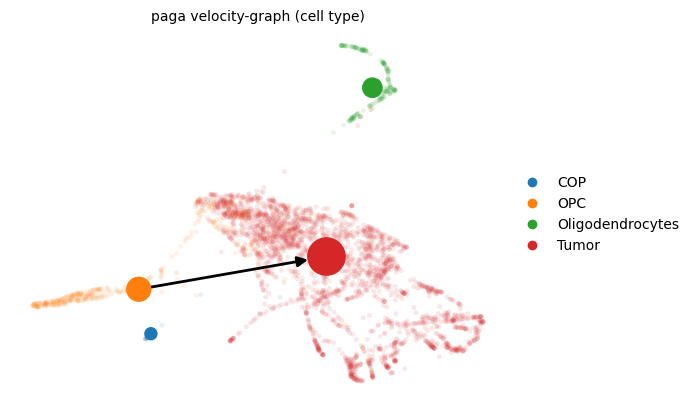

In [83]:
scv.pl.paga(adata, basis='draw_graph_fa', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5)

In [84]:
print(adata.var['velocity_genes'].sum(), adata.n_vars)


302 29008
